In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn import linear_model
from numpy import genfromtxt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier   
from sklearn.decomposition import PCA
from sklearn import tree
from imblearn.over_sampling import ADASYN 
from collections import Counter
from fancyimpute import KNN,BiScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier  
from sklearn import svm
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from  numpy  import   array
from  numpy  import  argmax
from  sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score as AUC
from  sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import  metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import confusion_matrix as CM,precision_score as P,recall_score as R
from sklearn.preprocessing import Normalizer

In [2]:
data = pd.read_csv('data1.csv')
x_data = data.iloc[:, 0:-1]
y_data = data.iloc[:, -1]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 0)

# ADASYN

In [3]:
adasyn = ADASYN(random_state=42)
resample_x, resample_y = adasyn.fit_sample(x_data, y_data)

In [4]:
print(resample_y.value_counts())

1    348
0    347
Name: outcome, dtype: int64


# LASSO

In [5]:
from sklearn.linear_model import LassoCV
clf1 = LassoCV(alphas = [0.13]).fit(resample_x, resample_y)
importance1 = np.abs(clf1.coef_)
print(importance1)

[0.00598874 0.         0.00111761 0.00438896 0.         0.02163727
 0.         0.00480782 0.00255303 0.0003958  0.         0.
 0.         0.00011588 0.         0.         0.        ]


In [6]:
m = np.flatnonzero(importance1).tolist()
m

[0, 2, 3, 5, 7, 8, 9, 13]

In [7]:
resample_x_lasso = resample_x.iloc[:,m]
x_data_lasso = x_data.iloc[:,m]

In [8]:
resample_x_lasso.head()

,Time to ROSC,ALP,PT,Plasma albumin,PaCO2,SOFA,AST,LDH
0,25,123,97,6.9,45,16,316,565
1,10,107,36,6.5,39,11,72,383
2,12,47,68,6.5,36,10,69,264
3,15,62,63,6.5,34,12,86,406
4,8,74,66,6.2,39,8,425,629


In [9]:
x_train, x_test, y_train, y_test = train_test_split(resample_x_lasso,resample_y,test_size = 0.2, random_state = 22)

In [10]:
##Find best threshold
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)  # Only the first occurrence is returned.
    optimal_threshold = threshold[Youden_index]
    optimal_point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, optimal_point

##compute ROC_AUC
def ROC(y_train, y_prob):
    """
    Receiver_Operating_Characteristic, ROC
    :param y_train: (n, )
    :param y_prob: (n, )
    :return: fpr, tpr, roc_auc, optimal_threshold, optimal_point
    """
    fpr, tpr, thresholds = roc_curve(y_train, y_prob)
    roc_auc = auc(fpr, tpr)
    optimal_threshold, optimal_point = Find_Optimal_Cutoff(TPR=tpr, FPR=fpr, threshold=thresholds)
    return fpr, tpr, roc_auc, optimal_threshold, optimal_point

##Predicting results using optimal thresholds
def new_pred(proba,optimal_threshold):
    proba_model = np.copy(proba)
    pred_proba = proba_model
    pred_proba[pred_proba < optimal_threshold.round(3)] = 0
    pred_proba[pred_proba >= optimal_threshold.round(3)] = 1
    pred = pred_proba
    return pred

# LR

In [11]:
import itertools
lr = LR(C=1,penalty="l2", solver = "liblinear", max_iter=100,random_state =42)
lr.fit(x_train,y_train)
y_pred_lr = lr.predict_proba(x_train)

In [12]:
print("AUC",AUC(y_train, y_pred_lr[:, 1]))

AUC 0.8651835171092821


In [13]:
##Predicting training set probabilities
prediction_train_proba_lr = lr.predict_proba(x_train)
# ##Predicting training set results
# prediction_train_lr = lr.predict(x_train_standard1)

fpr_train_lr, tpr_train_lr, auc_train_lr, optimal_threshold_lr, optimal_point = ROC(y_train,y_prob = prediction_train_proba_lr[:,1])

print('optimal_threshold:%.3f'%optimal_threshold_lr)
print(optimal_point)

optimal_threshold:0.444
[0.2591240875912409, 0.9361702127659575]


In [14]:
##Predicting test set probabilities
prediction_test_proba_lr = lr.predict_proba(x_test)
# ##Predicting test set results
# prediction_test_lr = lr.predict(x_test_standard1)

##compute fpr,tpr(recall)
fpr_test_lr, tpr_test_lr, thresholds = roc_curve(y_test, prediction_test_proba_lr[:,1])
##compute ROC_AUC
auc_test_lr = auc(fpr_test_lr, tpr_test_lr)


#Apply thresholds to define the predicted outcome
prediction_test_lr = new_pred(proba = prediction_test_proba_lr[:,1], optimal_threshold = optimal_threshold_lr)

print('auc_train_lr:%.3f'%auc_train_lr)
print('auc_test_lr:%.3f'%auc_test_lr)

a=confusion_matrix(y_test,prediction_test_lr)
print(a)
print('sensitivity:%.3f'%(a[1,1]/(a[1,1]+a[1,0])))
print('specifity:%.3f'%(a[0,0]/(a[0,0]+a[0,1])))
print('PPV:%.3f'%(a[1,1]/(a[1,1]+a[0,1])))
print('NPV:%.3f'%(a[0,0]/(a[0,0]+a[1,0])))

print('accuracy:%.3f'%accuracy_score(y_test, prediction_test_lr)) 
print('precision:%.3f'%precision_score(y_test, prediction_test_lr)) 
print('recall:%.3f'%recall_score(y_test, prediction_test_lr)) 
print('F1:%.3f'%f1_score(y_test, prediction_test_lr))  

auc_train_lr:0.865
auc_test_lr:0.864
[[52 21]
 [10 56]]
sensitivity:0.848
specifity:0.712
PPV:0.727
NPV:0.839
accuracy:0.777
precision:0.727
recall:0.848
F1:0.783


In [15]:
##Predicting test set probabilities
prediction_data_proba_lr = lr.predict_proba(x_data_lasso)
# ##Predicting test set results
# prediction_test_lr = lr.predict(x_test_standard1)

##compute fpr,tpr(recall)
fpr_data_lr, tpr_data_lr, thresholds = roc_curve(y_data, prediction_data_proba_lr[:,1])
##compute ROC_AUC
auc_data_lr = auc(fpr_data_lr, tpr_data_lr)


#Apply thresholds to define the predicted outcome
prediction_data_lr = new_pred(proba = prediction_data_proba_lr[:,1], optimal_threshold = optimal_threshold_lr)


print('auc_data_lr:%.3f'%auc_data_lr)

a=confusion_matrix(y_data,prediction_data_lr)
print(a)
print('sensitivity:%.3f'%(a[1,1]/(a[1,1]+a[1,0])))
print('specifity:%.3f'%(a[0,0]/(a[0,0]+a[0,1])))
print('PPV:%.3f'%(a[1,1]/(a[1,1]+a[0,1])))
print('NPV:%.3f'%(a[0,0]/(a[0,0]+a[1,0])))

print('accuracy:%.3f'%accuracy_score(y_data, prediction_data_lr)) 
print('precision:%.3f'%precision_score(y_data, prediction_data_lr)) 
print('recall:%.3f'%recall_score(y_data, prediction_data_lr)) 
print('F1:%.3f'%f1_score(y_data, prediction_data_lr))  

auc_data_lr:0.874
[[255  92]
 [  2  15]]
sensitivity:0.882
specifity:0.735
PPV:0.140
NPV:0.992
accuracy:0.742
precision:0.140
recall:0.882
F1:0.242


# RFC

In [16]:
rfc1 = RandomForestClassifier(max_depth=4,min_samples_split=25,min_samples_leaf=25,
                            n_estimators=100,random_state = 42)
rfc1.fit(x_train,y_train.ravel())

RandomForestClassifier(max_depth=4, min_samples_leaf=25, min_samples_split=25,
                       random_state=42)

In [17]:
prediction_train_proba_rfc = rfc1.predict_proba(x_train)

# prediction_train_rfc = rfc1.predict(x_train_standard1)

fpr_train_rfc, tpr_train_rfc, auc_train_rfc, optimal_threshold_rfc, optimal_point_rfc = ROC(y_train,y_prob = prediction_train_proba_rfc[:,1])

print('optimal_threshold:%.3f'%optimal_threshold_rfc)
print(optimal_point_rfc)

optimal_threshold:0.550
[0.12773722627737227, 0.9539007092198581]


In [18]:

prediction_test_proba_rfc = rfc1.predict_proba(x_test)

# prediction_test_rfc = rfc1.predict(x_test_standard1)


fpr_test_rfc, tpr_test_rfc, thresholds = roc_curve(y_test, prediction_test_proba_rfc[:,1])

auc_test_rfc = auc(fpr_test_rfc, tpr_test_rfc)



prediction_test_rfc = new_pred(proba = prediction_test_proba_rfc[:,1], optimal_threshold = optimal_threshold_rfc)

print('auc_train_rfc:%.3f'%auc_train_rfc)
print('auc_test_rfc:%.3f'%auc_test_rfc)

a=confusion_matrix(y_test,prediction_test_rfc)
print(a)
print('sensitivity:%.3f'%(a[1,1]/(a[1,1]+a[1,0])))
print('specifity:%.3f'%(a[0,0]/(a[0,0]+a[0,1])))
print('PPV:%.3f'%(a[1,1]/(a[1,1]+a[0,1])))
print('NPV:%.3f'%(a[0,0]/(a[0,0]+a[1,0])))

print('accuracy:%.3f'%accuracy_score(y_test, prediction_test_rfc)) 
print('precision:%.3f'%precision_score(y_test, prediction_test_rfc)) 
print('recall:%.3f'%recall_score(y_test, prediction_test_rfc)) 
print('F1:%.3f'%f1_score(y_test, prediction_test_rfc))  

auc_train_rfc:0.956
auc_test_rfc:0.933
[[63 10]
 [14 52]]
sensitivity:0.788
specifity:0.863
PPV:0.839
NPV:0.818
accuracy:0.827
precision:0.839
recall:0.788
F1:0.812


In [19]:

prediction_data_proba_rfc = rfc1.predict_proba(x_data_lasso)

# prediction_test_rfc = rfc1.predict(x_test_standard1)


fpr_data_rfc, tpr_data_rfc, thresholds = roc_curve(y_data, prediction_data_proba_rfc[:,1])

auc_data_rfc = auc(fpr_data_rfc, tpr_data_rfc)



prediction_data_rfc = new_pred(proba = prediction_data_proba_rfc[:,1], optimal_threshold = optimal_threshold_rfc)


print('auc_data_rfc:%.3f'%auc_data_rfc)

a=confusion_matrix(y_data,prediction_data_rfc)
print(a)
print('sensitivity:%.3f'%(a[1,1]/(a[1,1]+a[1,0])))
print('specifity:%.3f'%(a[0,0]/(a[0,0]+a[0,1])))
print('PPV:%.3f'%(a[1,1]/(a[1,1]+a[0,1])))
print('NPV:%.3f'%(a[0,0]/(a[0,0]+a[1,0])))

print('accuracy:%.3f'%accuracy_score(y_data, prediction_data_rfc)) 
print('precision:%.3f'%precision_score(y_data, prediction_data_rfc)) 
print('recall:%.3f'%recall_score(y_data, prediction_data_rfc)) 
print('F1:%.3f'%f1_score(y_data, prediction_data_rfc))  

auc_data_rfc:0.919
[[302  45]
 [  3  14]]
sensitivity:0.824
specifity:0.870
PPV:0.237
NPV:0.990
accuracy:0.868
precision:0.237
recall:0.824
F1:0.368


# svm

In [20]:
from sklearn import svm
svm=svm.SVC(C=1,gamma=0.1,kernel='linear',probability = True, random_state=20)
svm.fit(x_train,y_train.ravel())
y_pred_svm = svm.predict(x_train)
y_pred_svm_proba = svm.predict_proba(x_train)

In [21]:
prediction_train_proba_svm = svm.predict_proba(x_train)

# prediction_train_svm = svm.predict(x_train_standard1)

fpr_train_svm, tpr_train_svm, auc_train_svm, optimal_threshold_svm, optimal_point_svm = ROC(y_train,y_prob = prediction_train_proba_svm[:,1])

print('optimal_threshold:%.3f'%optimal_threshold_svm)
print(optimal_point_svm)

optimal_threshold:0.530
[0.20802919708029197, 0.8971631205673759]


In [22]:

prediction_test_proba_svm = svm.predict_proba(x_test)

# prediction_test_svm = svm.predict(x_test_standard1)

fpr_test_svm, tpr_test_svm, thresholds = roc_curve(y_test, prediction_test_proba_svm[:,1])

auc_test_svm = auc(fpr_test_svm, tpr_test_svm)



prediction_test_svm = new_pred(proba = prediction_test_proba_svm[:,1], optimal_threshold = optimal_threshold_svm)

print('auc_train_svm:%.3f'%auc_train_svm)
print('auc_test_svm:%.3f'%auc_test_svm)

a=confusion_matrix(y_test,prediction_test_svm)
print(a)
print('sensitivity:%.3f'%(a[1,1]/(a[1,1]+a[1,0])))
print('specifity:%.3f'%(a[0,0]/(a[0,0]+a[0,1])))
print('PPV:%.3f'%(a[1,1]/(a[1,1]+a[0,1])))
print('NPV:%.3f'%(a[0,0]/(a[0,0]+a[1,0])))

print('accuracy:%.3f'%accuracy_score(y_test, prediction_test_svm)) 
print('precision:%.3f'%precision_score(y_test, prediction_test_svm)) 
print('recall:%.3f'%recall_score(y_test, prediction_test_svm)) 
print('F1:%.3f'%f1_score(y_test, prediction_test_svm))  

auc_train_svm:0.862
auc_test_svm:0.863
[[56 17]
 [12 54]]
sensitivity:0.818
specifity:0.767
PPV:0.761
NPV:0.824
accuracy:0.791
precision:0.761
recall:0.818
F1:0.788


In [23]:
prediction_data_proba_svm = svm.predict_proba(x_data_lasso)

# prediction_test_svm = svm.predict(x_test_standard1)

fpr_data_svm, tpr_data_svm, thresholds = roc_curve(y_data, prediction_data_proba_svm[:,1])

auc_data_svm = auc(fpr_data_svm, tpr_data_svm)



prediction_data_svm = new_pred(proba = prediction_data_proba_svm[:,1], optimal_threshold = optimal_threshold_svm)


print('auc_data_svm:%.3f'%auc_data_svm)

a=confusion_matrix(y_data,prediction_data_svm)
print(a)
print('sensitivity:%.3f'%(a[1,1]/(a[1,1]+a[1,0])))
print('specifity:%.3f'%(a[0,0]/(a[0,0]+a[0,1])))
print('PPV:%.3f'%(a[1,1]/(a[1,1]+a[0,1])))
print('NPV:%.3f'%(a[0,0]/(a[0,0]+a[1,0])))

print('accuracy:%.3f'%accuracy_score(y_data, prediction_data_svm)) 
print('precision:%.3f'%precision_score(y_data, prediction_data_svm)) 
print('recall:%.3f'%recall_score(y_data, prediction_data_svm)) 
print('F1:%.3f'%f1_score(y_data, prediction_data_svm))  

auc_data_svm:0.866
[[273  74]
 [  3  14]]
sensitivity:0.824
specifity:0.787
PPV:0.159
NPV:0.989
accuracy:0.788
precision:0.159
recall:0.824
F1:0.267


# XGBOOST

In [24]:
other_params = {'n_estimators': 100, 'max_depth': 6, 'min_child_weight':8, 'seed': 1,
                    'gamma': 0.1,'colsample_bytree': 0.4, 'subsample': 0.4, 'reg_alpha': 0, 'reg_lambda': 1,'learning_rate': 0.1}
xgb = XGBClassifier(**other_params, random_state=20)

xgb.fit(x_train,y_train)

[11:19:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4,
              enable_categorical=False, gamma=0.1, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=8, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=20, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=1, subsample=0.4, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [25]:
prediction_train_proba_xgb = xgb.predict_proba(x_train)

# prediction_train_xgb = xgb.predict(x_train_standard1)

fpr_train_xgb, tpr_train_xgb, auc_train_xgb, optimal_threshold_xgb, optimal_point_xgb = ROC(y_train,y_prob = prediction_train_proba_xgb[:,1])

print('optimal_threshold:%.3f'%optimal_threshold_xgb)
print(optimal_point_xgb)

optimal_threshold:0.593
[0.072992700729927, 0.9609929078014184]


In [26]:

prediction_test_proba_xgb = xgb.predict_proba(x_test)

# prediction_test_xgb = xgb.predict(x_test_standard1)


fpr_test_xgb, tpr_test_xgb, thresholds = roc_curve(y_test, prediction_test_proba_xgb[:,1])

auc_test_xgb = auc(fpr_test_xgb, tpr_test_xgb)



prediction_test_xgb = new_pred(proba = prediction_test_proba_xgb[:,1], optimal_threshold = optimal_threshold_xgb)

print('auc_train_xgb:%.3f'%auc_train_xgb)
print('auc_test_xgb:%.3f'%auc_test_xgb)

a=confusion_matrix(y_test,prediction_test_xgb)
print(a)
print('sensitivity:%.3f'%(a[1,1]/(a[1,1]+a[1,0])))
print('specifity:%.3f'%(a[0,0]/(a[0,0]+a[0,1])))
print('PPV:%.3f'%(a[1,1]/(a[1,1]+a[0,1])))
print('NPV:%.3f'%(a[0,0]/(a[0,0]+a[1,0])))

print('accuracy:%.3f'%accuracy_score(y_test, prediction_test_xgb)) 
print('precision:%.3f'%precision_score(y_test, prediction_test_xgb)) 
print('recall:%.3f'%recall_score(y_test, prediction_test_xgb)) 
print('F1:%.3f'%f1_score(y_test, prediction_test_xgb))  

auc_train_xgb:0.969
auc_test_xgb:0.952
[[64  9]
 [ 6 60]]
sensitivity:0.909
specifity:0.877
PPV:0.870
NPV:0.914
accuracy:0.892
precision:0.870
recall:0.909
F1:0.889


In [27]:

prediction_data_proba_xgb = xgb.predict_proba(x_data_lasso)

# prediction_test_xgb = xgb.predict(x_test_standard1)


fpr_data_xgb, tpr_data_xgb, thresholds = roc_curve(y_data, prediction_data_proba_xgb[:,1])

auc_data_xgb = auc(fpr_data_xgb, tpr_data_xgb)



prediction_data_xgb = new_pred(proba = prediction_data_proba_xgb[:,1], optimal_threshold = optimal_threshold_xgb)

print('auc_data_xgb:%.3f'%auc_data_xgb)


a=confusion_matrix(y_data,prediction_data_xgb)
print(a)
print('sensitivity:%.3f'%(a[1,1]/(a[1,1]+a[1,0])))
print('specifity:%.3f'%(a[0,0]/(a[0,0]+a[0,1])))
print('PPV:%.3f'%(a[1,1]/(a[1,1]+a[0,1])))
print('NPV:%.3f'%(a[0,0]/(a[0,0]+a[1,0])))

print('accuracy:%.3f'%accuracy_score(y_data, prediction_data_xgb)) 
print('precision:%.3f'%precision_score(y_data, prediction_data_xgb)) 
print('recall:%.3f'%recall_score(y_data, prediction_data_xgb)) 
print('F1:%.3f'%f1_score(y_data, prediction_data_xgb))  

auc_data_xgb:0.947
[[318  29]
 [  2  15]]
sensitivity:0.882
specifity:0.916
PPV:0.341
NPV:0.994
accuracy:0.915
precision:0.341
recall:0.882
F1:0.492


In [28]:
a = pd.DataFrame(prediction_test_proba_lr)
b = pd.DataFrame(prediction_test_proba_rfc)
c = pd.DataFrame(prediction_test_proba_svm)
d = pd.DataFrame(prediction_test_proba_xgb)
a.to_csv("lr_test.csv")
b.to_csv("rfc_test.csv")
c.to_csv("svm_test.csv")
d.to_csv("xgb_test.csv")

In [29]:
e = pd.DataFrame(y_test)
e.to_csv("y_test.csv")

In [30]:
f = pd.DataFrame(prediction_data_proba_xgb)
f.to_csv("xgb_data.csv")

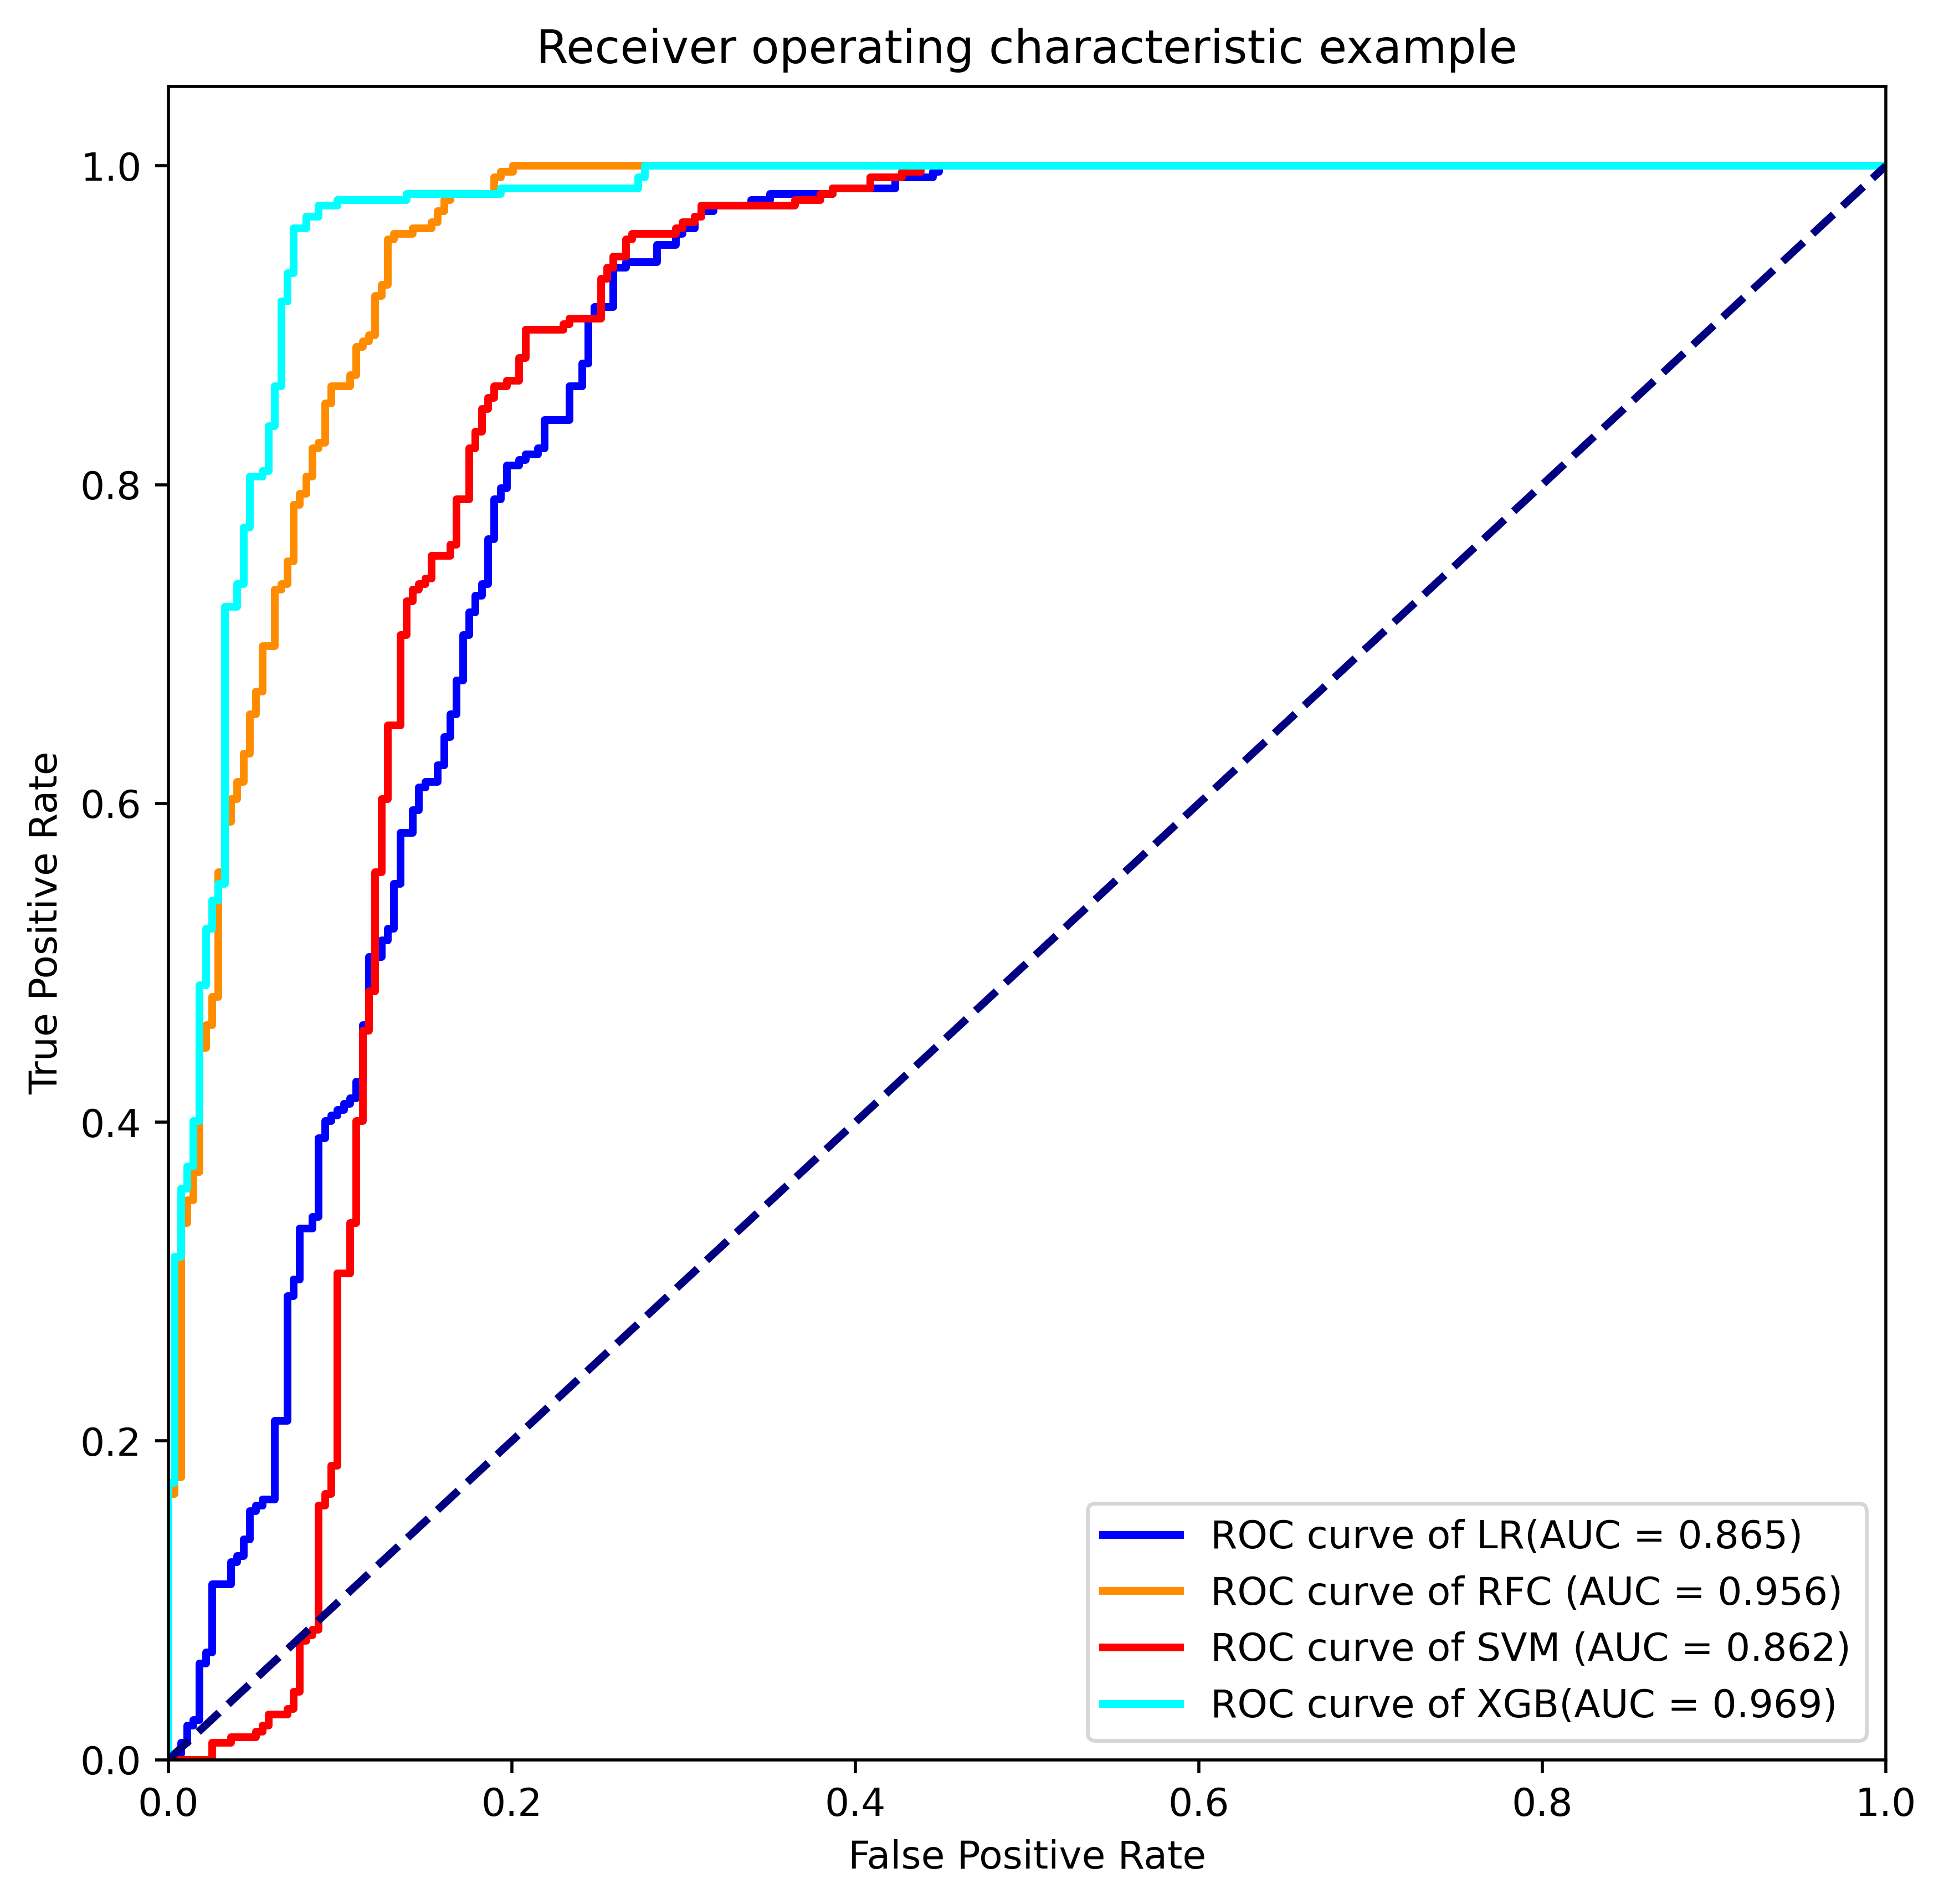

In [31]:
plt.figure(figsize=(8,8),dpi=500)

plt.plot(fpr_train_lr, tpr_train_lr, color='blue',lw=2, label='ROC curve of LR(AUC = %0.3f)' % auc_train_lr) #假正率为横坐标，真正率为纵坐标做曲线
plt.plot(fpr_train_rfc, tpr_train_rfc, color='darkorange',lw=2, label='ROC curve of RFC (AUC = %0.3f)' % auc_train_rfc) 
plt.plot(fpr_train_svm, tpr_train_svm, color='red',lw=2, label='ROC curve of SVM (AUC = %0.3f)' % auc_train_svm) 
plt.plot(fpr_train_xgb, tpr_train_xgb, color='cyan',lw=2, label='ROC curve of XGB(AUC = %0.3f)' % auc_train_xgb) 



plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

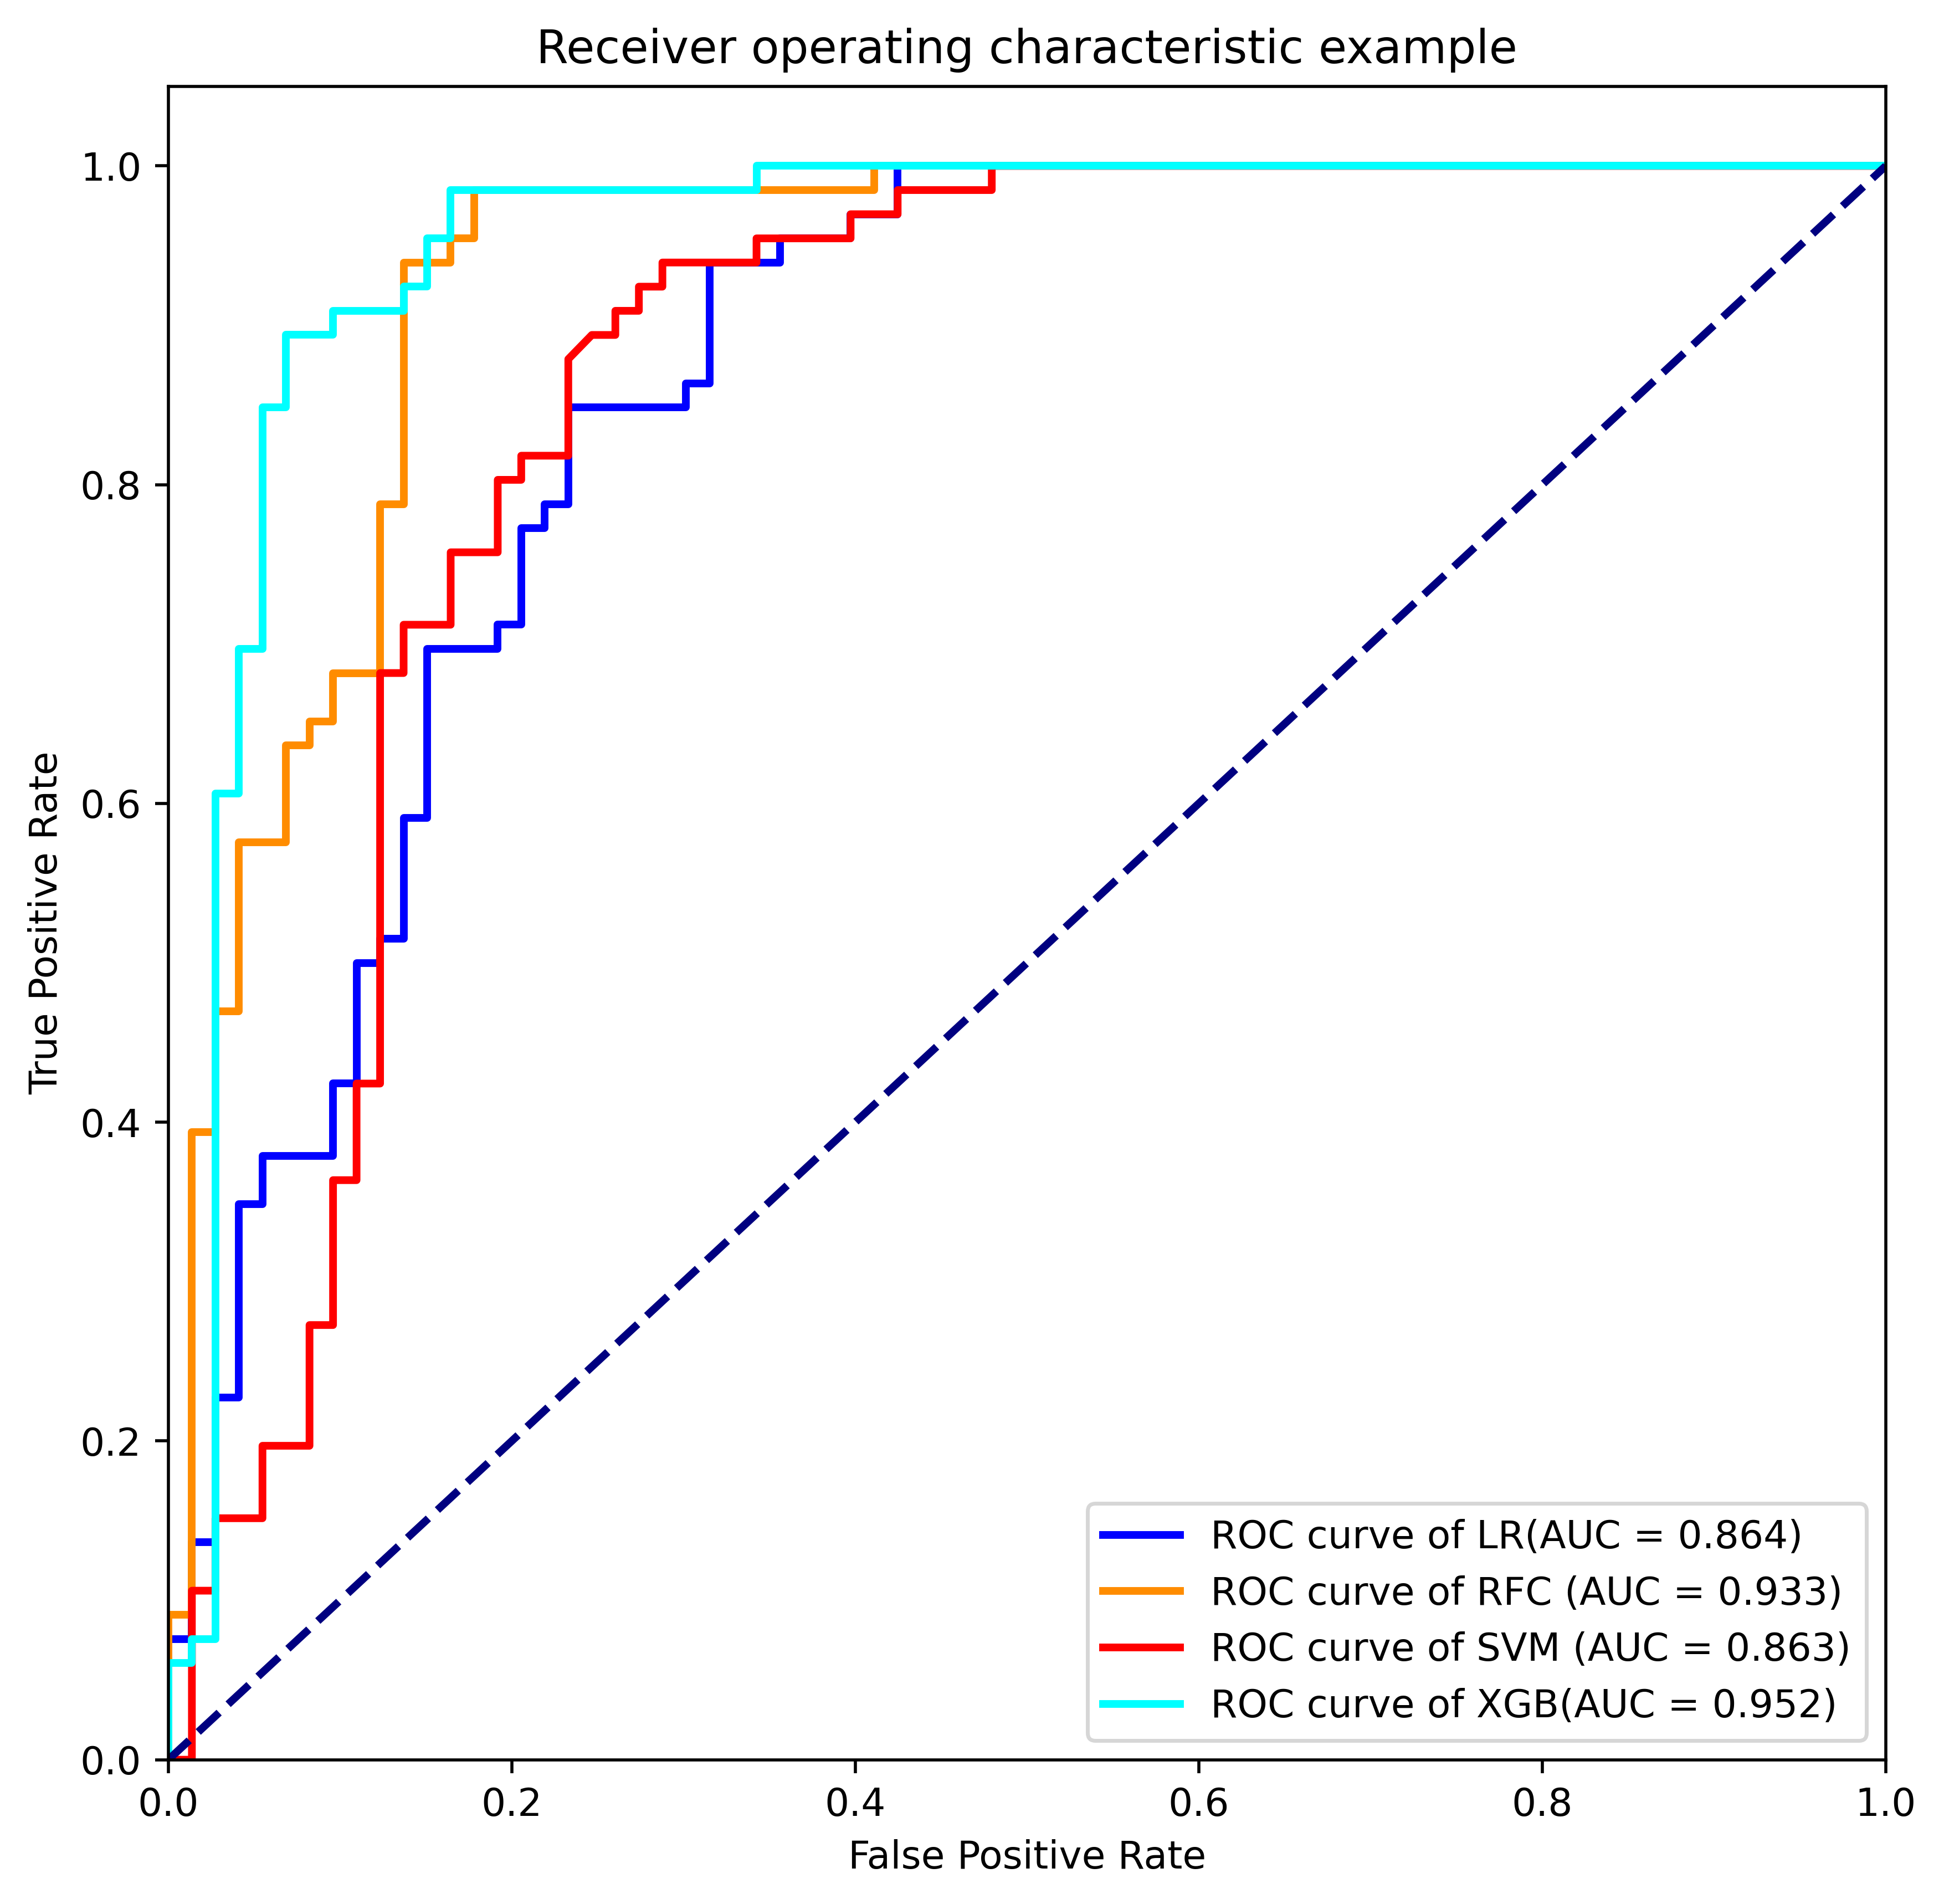

In [32]:
plt.figure(figsize=(8,8), dpi=500)

plt.plot(fpr_test_lr, tpr_test_lr, color='blue',lw=2, label='ROC curve of LR(AUC = %0.3f)' % auc_test_lr) #假正率为横坐标，真正率为纵坐标做曲线
plt.plot(fpr_test_rfc, tpr_test_rfc, color='darkorange',lw=2, label='ROC curve of RFC (AUC = %0.3f)' % auc_test_rfc) 
plt.plot(fpr_test_svm, tpr_test_svm, color='red',lw=2, label='ROC curve of SVM (AUC = %0.3f)' % auc_test_svm) 
plt.plot(fpr_test_xgb, tpr_test_xgb, color='cyan',lw=2, label='ROC curve of XGB(AUC = %0.3f)' % auc_test_xgb) 


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

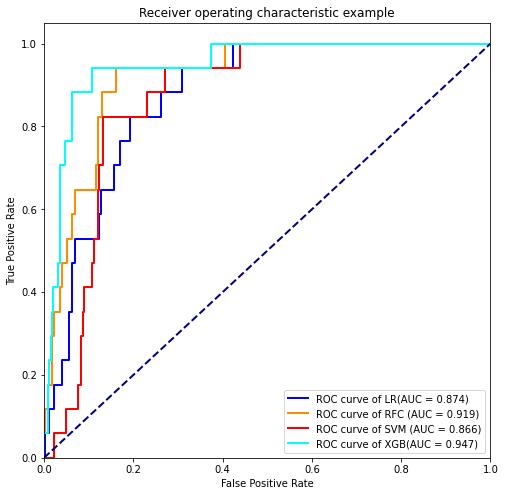

In [33]:
plt.figure(figsize=(8,8))

plt.plot(fpr_data_lr, tpr_data_lr, color='blue',lw=2, label='ROC curve of LR(AUC = %0.3f)' % auc_data_lr) #假正率为横坐标，真正率为纵坐标做曲线
plt.plot(fpr_data_rfc, tpr_data_rfc, color='darkorange',lw=2, label='ROC curve of RFC (AUC = %0.3f)' % auc_data_rfc) 
plt.plot(fpr_data_svm, tpr_data_svm, color='red',lw=2, label='ROC curve of SVM (AUC = %0.3f)' % auc_data_svm)
plt.plot(fpr_data_xgb, tpr_data_xgb, color='cyan',lw=2, label='ROC curve of XGB(AUC = %0.3f)' % auc_data_xgb) 


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Calibration curve

In [33]:
from sklearn.datasets import make_classification as mc
from sklearn.metrics import brier_score_loss 
from sklearn.calibration import calibration_curve 
from sklearn.linear_model import LinearRegression

In [34]:
name = ["LR","RFC",'SVM','XGB']
name1 = ["LR","RFC",'XGB']

LR:
	Brier: 0.150 slope:1.058 intercept:-0.024
RFC:
	Brier: 0.107 slope:1.306 intercept:-0.140
SVM:
	Brier: 0.146 slope:1.218 intercept:-0.107
XGB:
	Brier: 0.080 slope:1.179 intercept:-0.106


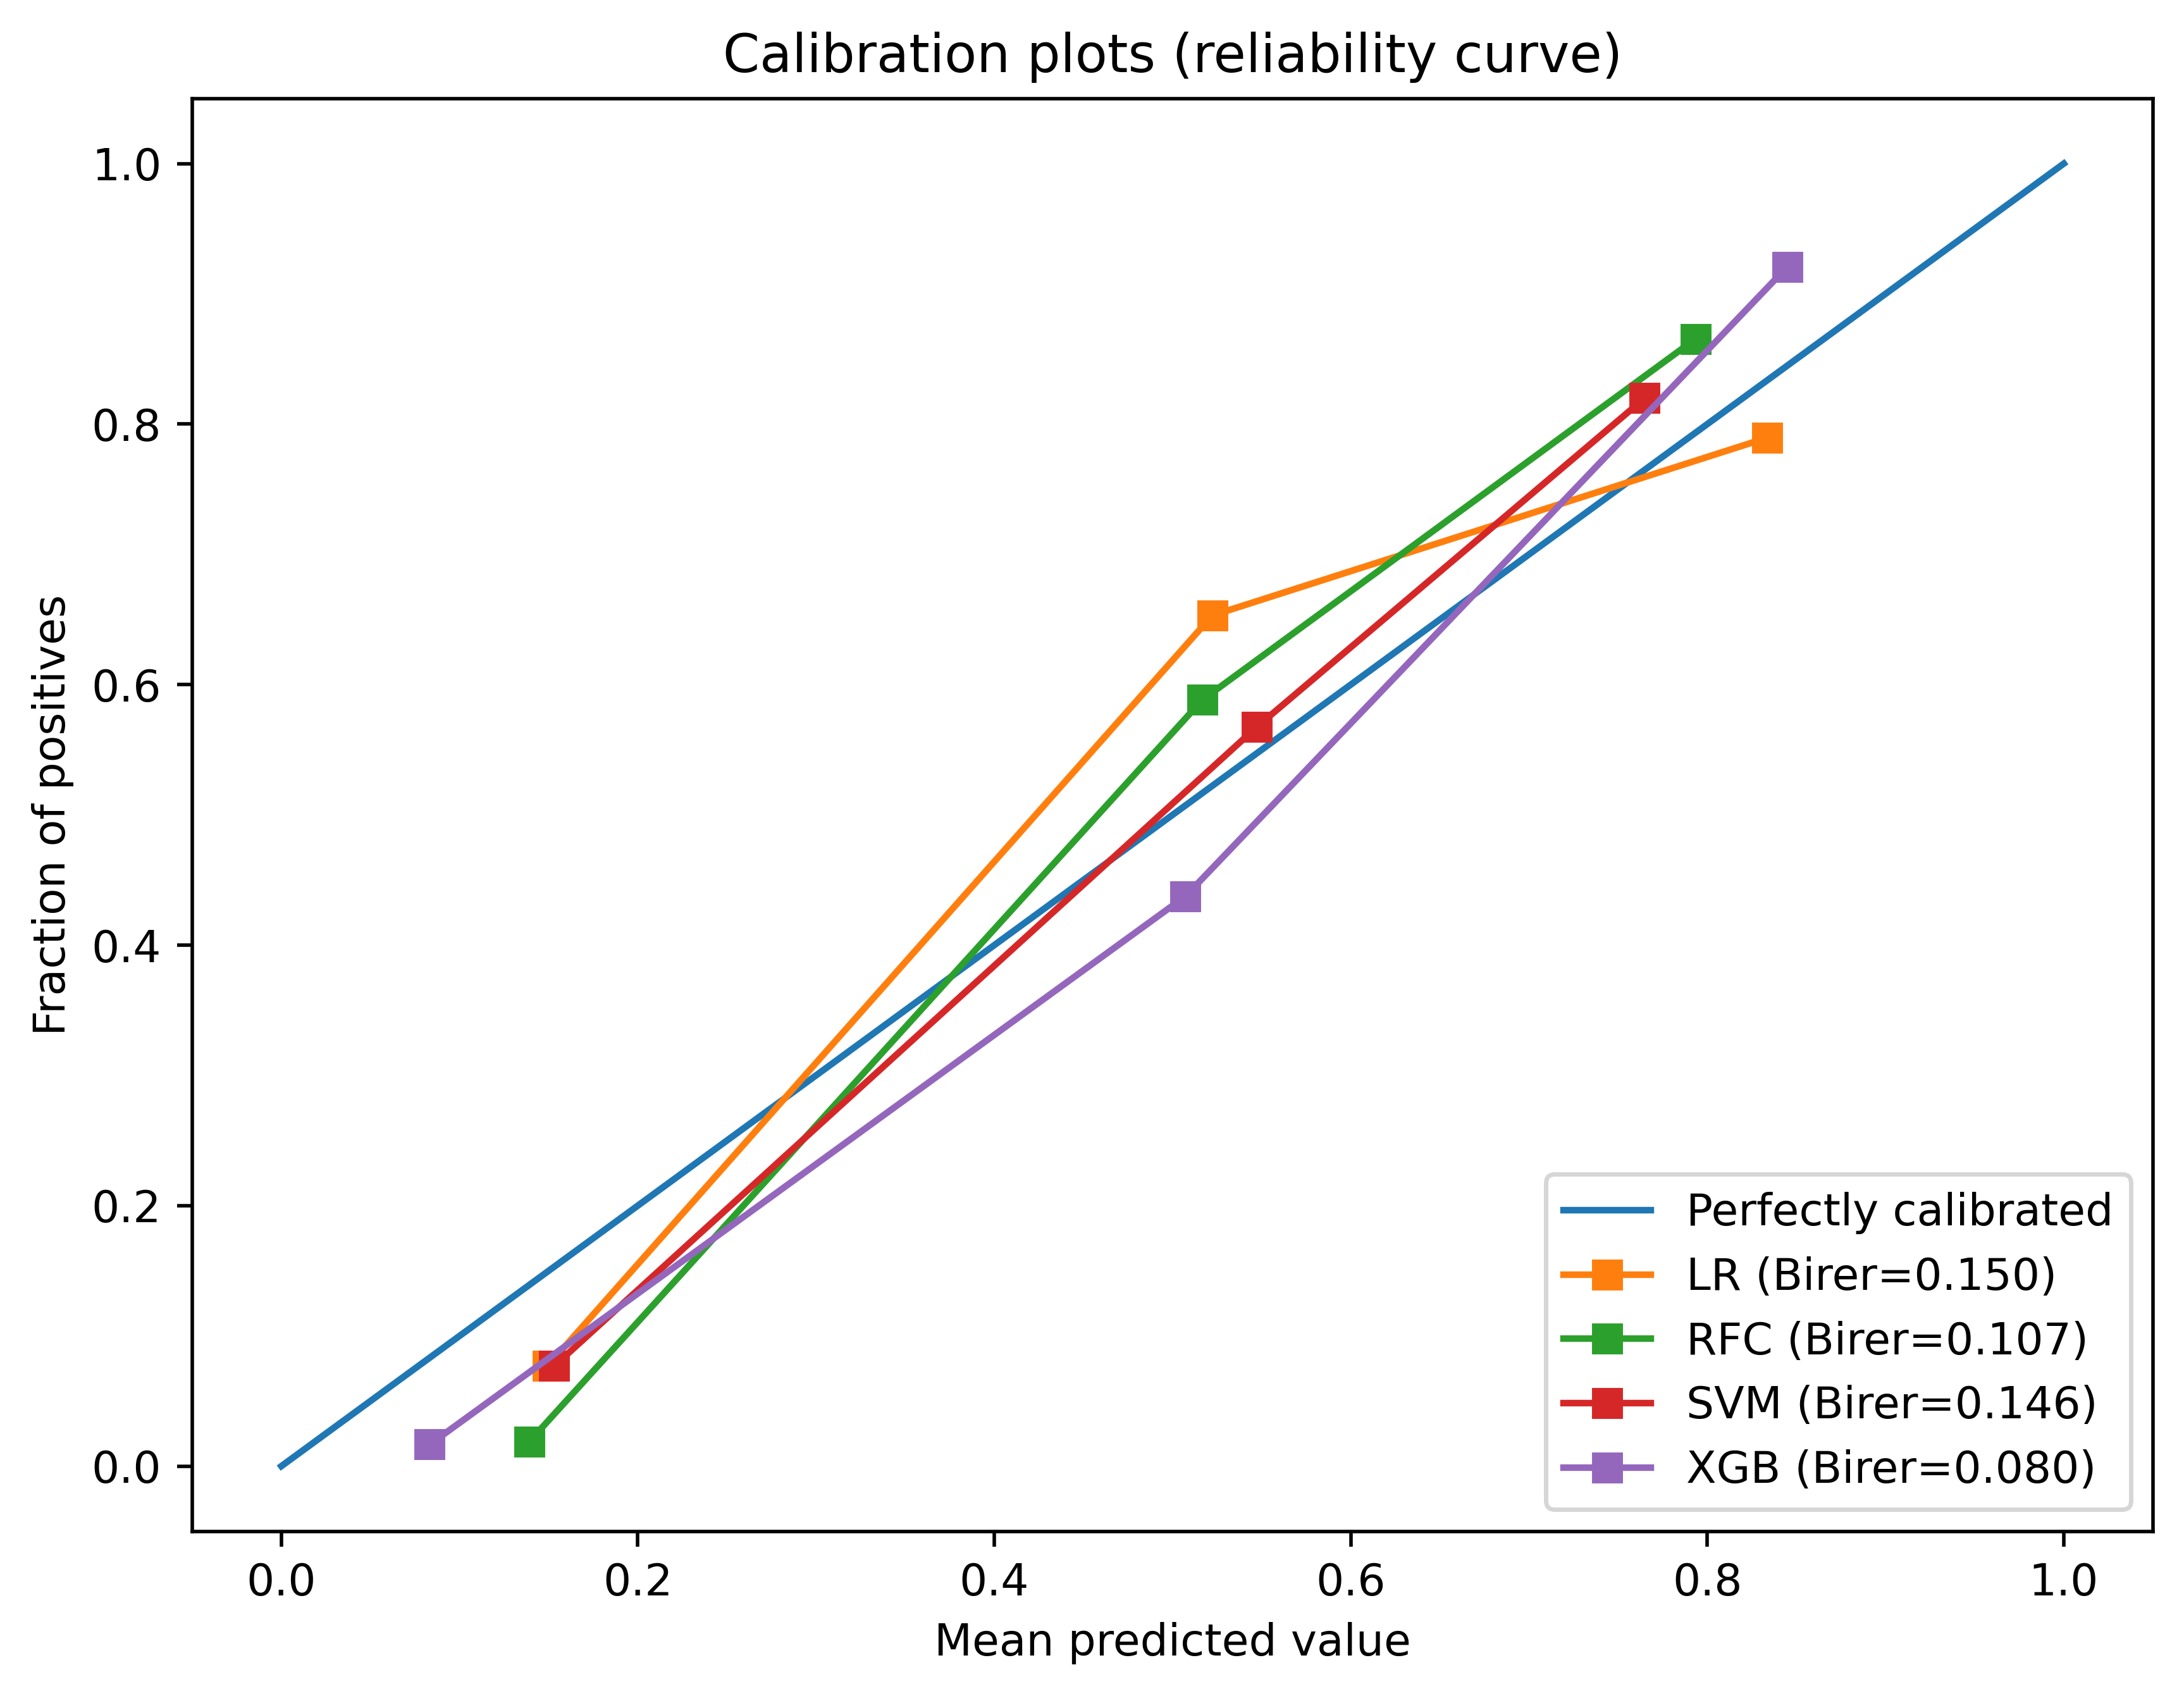

In [35]:
#fraction_of_positives trueproba, mean_predicted_value predproba.
plt.figure(figsize=(8,6),dpi=500)
plt.plot([0,1],[0,1],label = "Perfectly calibrated") 
for clf,name_ in zip([lr,rfc1,svm,xgb],name):
    
    
    if name_ == 'DNN':        
        proba_pos = clf.predict(x_test)
    else:                
        proba_pos = clf.predict_proba(x_test)[:, 1]
    
    clf_score = brier_score_loss(y_test, proba_pos)
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, proba_pos, n_bins=3)
    model= LinearRegression()
    model.fit(mean_predicted_value.reshape(-1,1),fraction_of_positives.reshape(-1,1))
    print("%s:" % name_)
    print("\tBrier: %1.3f" % (clf_score),'slope:%1.3f'%model.coef_ ,'intercept:%1.3f'%model.intercept_)
    plt.plot(mean_predicted_value, fraction_of_positives, "s-",label="%s (Birer=%1.3f)" % (name_, clf_score))

plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")
plt.title('Calibration plots (reliability curve)')

plt.show()


# null score

In [40]:
proba_pos = pd.read_csv('y_test_prob.csv')

clf_score = brier_score_loss(y_test, proba_pos)

In [41]:
clf_score

0.24936600719424468